<a href="https://colab.research.google.com/github/adnan119/Pytorch-Projects/blob/main/InceptionNet/InceptionNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implementing original InceptionNet Model**

###**Key Highlights from the Model:**


*   Because of the huge variation in the location of the information i.e. the variations in the main object to be classified present, choosing the right kernel size for the convolution operation becomes tough. A larger kernel is preferred for information that is distributed more globally, and a smaller kernel is preferred for information that is distributed more locally.
*   **Solution:** Why not have filters with multiple sizes operate on the same level? The network essentially would get a bit “wider” rather than “deeper”.
* Deep neural networks are computationally expensive. To make it cheaper, the authors limit the number of input channels by adding an extra 1x1 convolution before the 3x3 and 5x5 convolutions. Though adding an extra operation may seem counterintuitive, 1x1 convolutions are far more cheaper than 5x5 convolutions, and the reduced number of input channels also help.
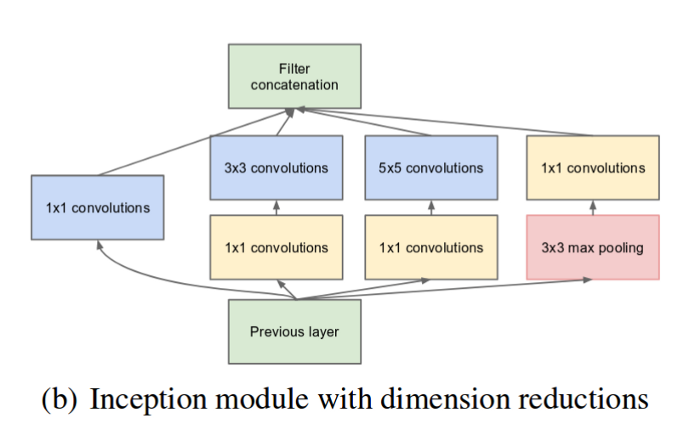
* Needless to say, it is a pretty deep classifier. As with any very deep network, it is subject to the vanishing gradient problem.
To prevent the middle part of the network from “dying out”, the authors introduced two auxiliary classifiers (The purple boxes in the image). They essentially applied softmax to the outputs of two of the inception modules, and computed an auxiliary loss over the same labels. The total loss function is a weighted sum of the auxiliary loss and the real loss. Weight value used in the paper was 0.3 for each auxiliary loss.


##**Spatially separable convolutions**
Convolutions that can be separated across their spatial axes.
One of the most famous convolutions that can be separated spatially is the Sobel kernel, used to detect edges.
**[Spatially seperable Convolutions](https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728)**

In [ ]:
!pip install torchviz

In [25]:
import torch 
import torch.nn as nn
import cv2
import imutils

from google.colab.patches import cv2_imshow

from torchviz import make_dot

In [2]:
class conv_block(nn.Module):
  def __init__(self, in_channels, out_channels, **kwargs):
    super(conv_block, self).__init__()
    self.relu = nn.ReLU()
    self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
    self.batchnorm = nn.BatchNorm2d(out_channels)

  def forward(self,x):
    x = self.conv(x)
    x = self.batchnorm(x)
    x = self.relu(x)
    return x

In [8]:
class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.7)
        self.pool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv = conv_block(in_channels, 128, kernel_size=1)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [9]:
class inception_block(nn.Module):
  def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_max_1x1):
    super(inception_block, self).__init__()


    self.branch_1 = conv_block(in_channels, out_1x1, kernel_size=1)


    self.branch_2 = nn.Sequential(
        conv_block(in_channels, red_3x3, kernel_size=1),
        conv_block(red_3x3, out_3x3, kernel_size=3, padding=1)
    )


    self.branch_3 = nn.Sequential(
        conv_block(in_channels, red_5x5, kernel_size = 1),
        conv_block(red_5x5, out_5x5, kernel_size=5, padding=2)
    )


    self.branch_4 = nn.Sequential(
        nn.MaxPool2d(kernel_size=3, stride = 1, padding=1),
        conv_block(in_channels, out_max_1x1, kernel_size=1)
    )

  def forward(self, x):
    return torch.cat([self.branch_1(x), self.branch_2(x), self.branch_3(x), self.branch_4(x)], 1)

In [12]:
class InceptionNet(nn.Module):
  def __init__(self, aux_logits=True, in_channels=3, num_classes=1000):
    super(InceptionNet, self).__init__()
    assert aux_logits == True or aux_logits == False
    self.aux_logits = aux_logits

    self.conv1 = conv_block(in_channels, out_channels=64, kernel_size=(7,7), stride=(2,2), padding=(3,3))
    self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride = 2, padding=1)
    self.conv2 = conv_block(64, 192, kernel_size=3, stride=1, padding=1)
    self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    # In this order: in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool
    self.inception3a = inception_block(192, 64, 96, 128, 16, 32, 32)
    self.inception3b = inception_block(256, 128, 128, 192, 32, 96, 64)
    self.maxpool3 = nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=1)

    self.inception4a = inception_block(480, 192, 96, 208, 16, 48, 64)
    self.inception4b = inception_block(512, 160, 112, 224, 24, 64, 64)
    self.inception4c = inception_block(512, 128, 128, 256, 24, 64, 64)
    self.inception4d = inception_block(512, 112, 144, 288, 32, 64, 64)
    self.inception4e = inception_block(528, 256, 160, 320, 32, 128, 128)
    self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.inception5a = inception_block(832, 256, 160, 320, 32, 128, 128)
    self.inception5b = inception_block(832, 384, 192, 384, 48, 128, 128)

    self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
    self.dropout = nn.Dropout(p=0.4)
    self.fc1 = nn.Linear(1024, num_classes)


    if self.aux_logits:
      self.aux1 = InceptionAux(512, num_classes)
      self.aux2 = InceptionAux(528, num_classes)
    else:
      self.aux1 = self.aux2 = None


  def forward(self, x):

    x = self.conv1(x)
    x = self.maxpool1(x)
    x = self.conv2(x)
    # x = self.conv3(x)
    x = self.maxpool2(x)

    x = self.inception3a(x)
    x = self.inception3b(x)
    x = self.maxpool3(x)

    x = self.inception4a(x)

    if self.aux_logits and self.training:
      aux1 = self.aux1(x)

    x = self.inception4b(x)
    x = self.inception4c(x)
    x = self.inception4d(x)

    if self.aux_logits and self.training:
      aux2 = self.aux2(x)

    x = self.inception4e(x)
    x = self.maxpool4(x)
    x = self.inception5a(x)
    x = self.inception5b(x)
    x = self.avgpool(x)
    x = x.reshape(x.shape[0], -1)
    x = self.dropout(x)
    x = self.fc1(x)

    if self.aux_logits and self.training:
        return aux1, aux2, x
    else:
        return x

In [15]:
x = torch.randn(3, 3, 224, 224)
model = InceptionNet(num_classes=1000)
y = model(x)

In [20]:
make_dot(y, params=dict(model.named_parameters())).render("rnn_torchviz", format="png")

'rnn_torchviz.png'

In [23]:
m = cv2.imread("inception.png")
print(m.shape)

(6640, 6099, 3)


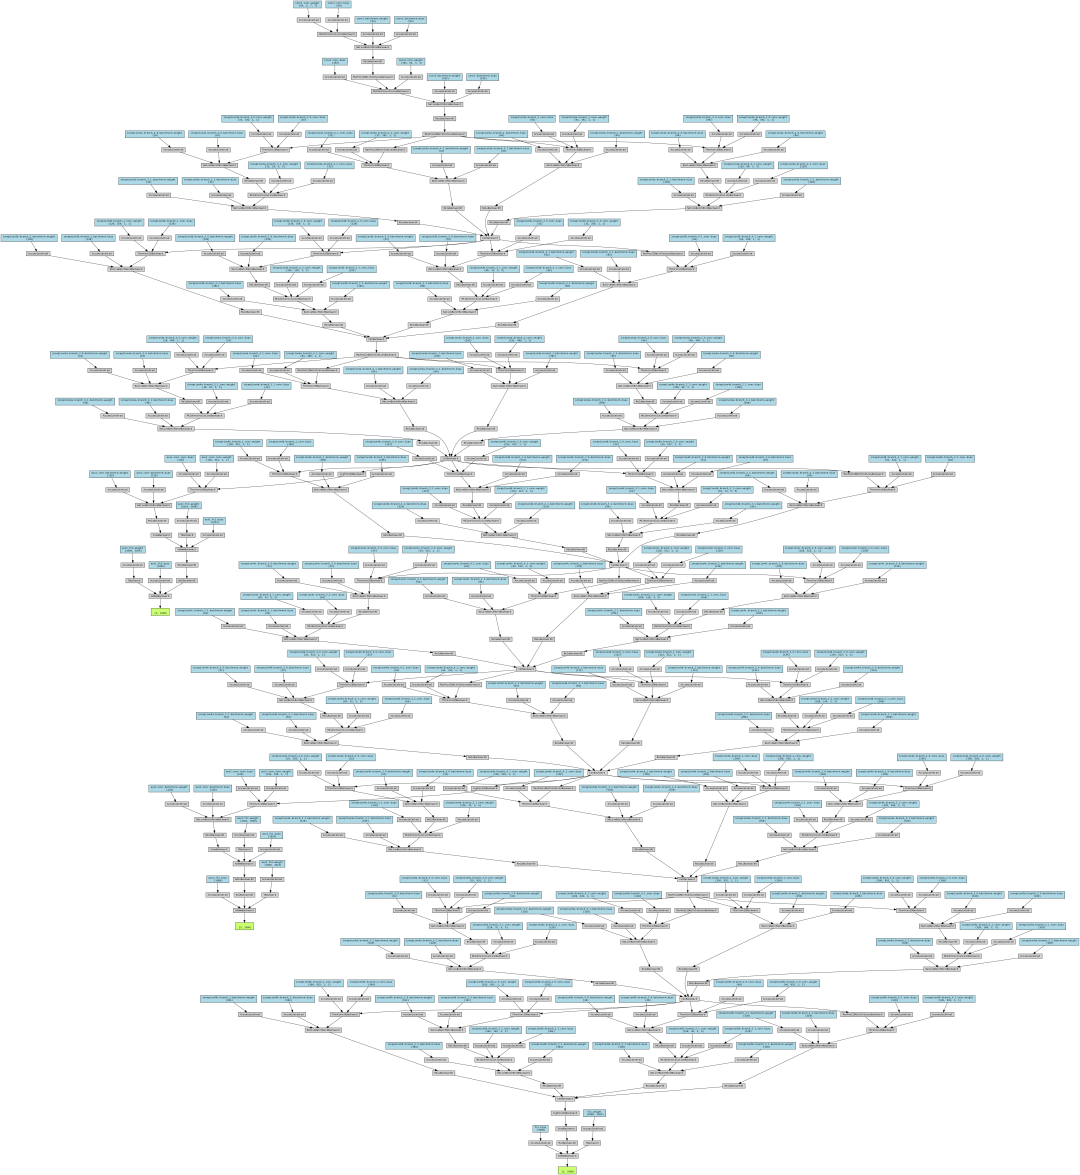

In [28]:
ms = imutils.resize(m , width=1080)
cv2_imshow(ms)